In [1]:
import tensorflow as tf
import os
import numpy as np
import IPython.display as display
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [2]:
import pandas as pd
import random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH,IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
#https://www.kaggle.com/tongpython/cat-and-dog#cat.4009.jpg
DATA_DIR='cat-and-dog'#this is where you store the folder

In [4]:
train_cat_ds = tf.data.Dataset.list_files(DATA_DIR + '/training_set/cats/*')
train_dog_ds = tf.data.Dataset.list_files(DATA_DIR + '/training_set/dogs/*')
test_cat_ds = tf.data.Dataset.list_files(DATA_DIR +'/test_set/cats/*')
test_dog_ds = tf.data.Dataset.list_files(DATA_DIR +'/test_set/dogs/*')

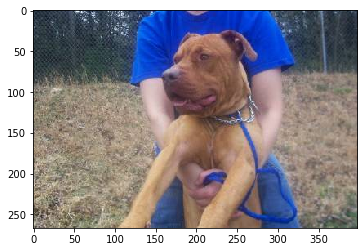

In [5]:
for i in train_dog_ds.take(1):
    img = load_img(i.numpy())
    plt.imshow(img)
    plt.show()

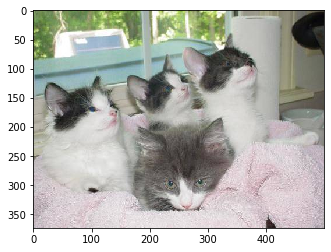

In [6]:
for i in train_cat_ds.take(1):
    img = load_img(i.numpy())
    plt.imshow(img)
    plt.show()

In [7]:
def load_image(filename_tensor):
    img = tf.io.read_file(filename_tensor)
    img = tf.image.decode_jpeg(img,channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])
    return img

train_cat_img = train_cat_ds.map(load_image)
train_dog_img = train_dog_ds.map(load_image)
test_cat_img = test_cat_ds.map(load_image)
test_dog_img = test_dog_ds.map(load_image)

In [8]:
#cat=0,dog=1
train_cat = np.array([np.array([f.numpy(),0]) for f in train_cat_img])
train_dog = np.array([np.array([f.numpy(),1]) for f in train_dog_img])
test_cat = np.array([np.array([f.numpy(),0]) for f in test_cat_img])
test_dog = np.array([np.array([f.numpy(),1]) for f in test_dog_img])

train_data = np.concatenate((train_cat,train_dog))
test_data = np.concatenate((test_cat,test_dog))

np.random.shuffle(train_data)
np.random.shuffle(test_data)

train_X = np.array([x[0] for x in train_data])
train_y = np.array([y[1] for y in train_data])

test_X = np.array([x[0] for x in test_data])
test_y = np.array([y[1] for y in test_data])

In [9]:
print(train_X.shape)
print(train_y.shape)

print(test_X.shape)
print(test_y.shape)

(8005, 128, 128, 3)
(8005,)
(2022, 128, 128, 3)
(2022,)


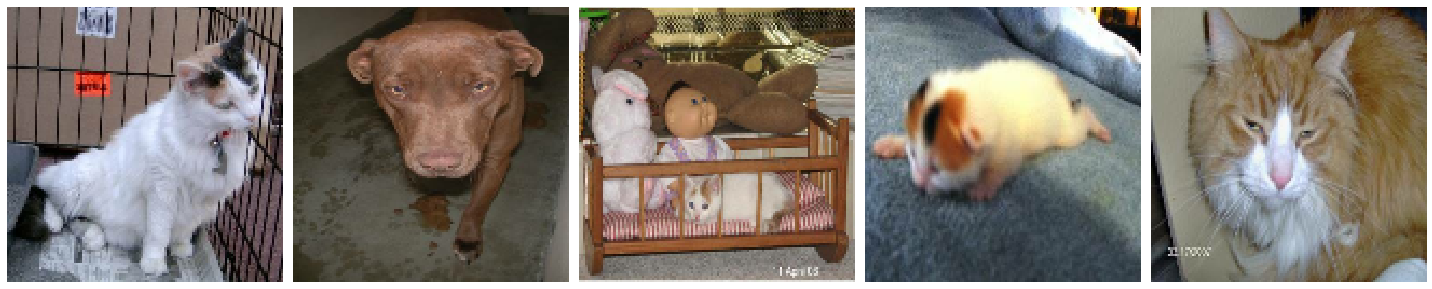

In [10]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(np.squeeze(img))
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
#Sample images after processings
plotImages(train_X[:5])

In [11]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

cnn_clf = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((3,3)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((3,3)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(128, (2, 2), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')])

cnn_clf.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
cnn_clf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 40, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0

In [22]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=5)

EPOCHS = 10
cnn_history = cnn_clf.fit(
    train_X,
    train_y,
    validation_split=0.2,
    epochs=EPOCHS,
    #callbacks=[earlystop]
    )

Train on 6404 samples, validate on 1601 samples
Epoch 1/10
6404/6404 [==============================] - 58s 9ms/sample - loss: 0.1276 - accuracy: 0.9513 - val_loss: 1.6189 - val_accuracy: 0.7377
Epoch 2/10
6404/6404 [==============================] - 62s 10ms/sample - loss: 0.1251 - accuracy: 0.9521 - val_loss: 0.3660 - val_accuracy: 0.8332
Epoch 3/10
6404/6404 [==============================] - 65s 10ms/sample - loss: 0.1176 - accuracy: 0.9563 - val_loss: 0.4870 - val_accuracy: 0.7683
Epoch 4/10
6404/6404 [==============================] - 68s 11ms/sample - loss: 0.1171 - accuracy: 0.9539 - val_loss: 0.4505 - val_accuracy: 0.8064
Epoch 5/10
6404/6404 [==============================] - 68s 11ms/sample - loss: 0.1119 - accuracy: 0.9572 - val_loss: 0.4981 - val_accuracy: 0.8220
Epoch 6/10
6404/6404 [==============================] - 66s 10ms/sample - loss: 0.1122 - accuracy: 0.9571 - val_loss: 0.5100 - val_accuracy: 0.8120
Epoch 7/10
6404/6404 [==============================] - 67s 10ms/

In [23]:
res = cnn_clf.evaluate(test_X,test_y,verbose=2)
print(res)

2022/1 - 7s - loss: 0.3229 - accuracy: 0.8501
[0.5404821437452832, 0.8501484]


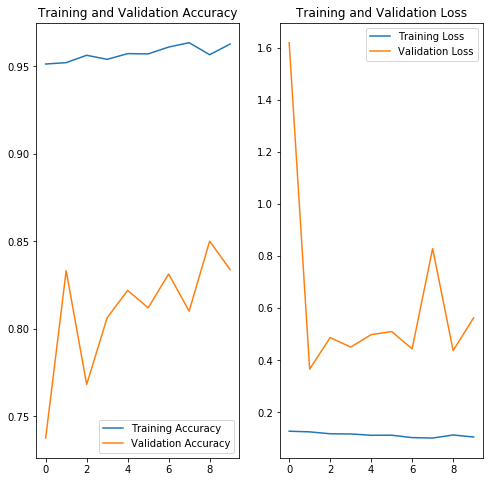

In [25]:
acc = cnn_history.history['accuracy']
val_acc = cnn_history.history['val_accuracy']

loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()